This notebook shows how the library can be used. 
First we read the videos, then we process them and finally we train a model

In [6]:
import pandas as pd
import csv
import os
import re
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
from token import EXACT_TOKEN_TYPES
from sklearn.metrics import accuracy_score # Accuracy metrics 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
import pickle

from collections import deque
import numpy as np

In [7]:
%%timeit

# Initialize an empty deque
float_deque = deque()

# Simulate appending values using a for loop
for i in range(1000):
    value =  np.array([1,2,3,4,5,6])*0.5  # Replace this line with your actual value calculation
    float_deque.append(value)

# Convert the deque to a NumPy array
float_array = np.array(float_deque, dtype=float)


2.15 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# GLOBAL VARIABLES
PATH = r'D:\\Proyectos\\Hands\\HigieneManos' # path to folder
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.4, min_tracking_confidence=0.4, max_num_hands = 2,static_image_mode=True) # modelo

In [9]:
def get_videos_path(root_folder):
    '''
    Function to get all the video paths that are in certain root_folder organized using Stepx folders.
    Parameters
    ----------
    root_folder:str
        The root folder containing the Stepx organized folders.

    Returns
    ----------
    video_paths: list 
        A list of lists where each inner list contains the step number and the corresponding video path.
    '''
    # Regular expression to extract step folder number
    step_regex = re.compile(r'step(\d+)', flags=re.IGNORECASE)  
    video_paths = []

    if not os.path.exists(root_folder):
        print(f"Error: The folder {root_folder} does not exist.")
        return

    # Traverse through the root folder
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if it's a directory and named "step"
        if os.path.isdir(folder_path) and step_regex.search(folder_name.lower()):
            print(f"Reading files in {folder_path}:")

            match = step_regex.search(folder_name)
            step_number = int(match.group(1)) if match else None

            # Traverse through the "step" folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Check if it's a file and has a ".mp4" extension
                if os.path.isfile(file_path) and file_name.lower().endswith(".mp4"):
                    #print(f"Reading {file_path}:")
                    video_paths.append([step_number,file_path])
    return video_paths


In [10]:
video_paths = get_videos_path(PATH+r'\\Data\\Videos')

Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step1:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step2:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step3:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step4:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step5:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step6:


In [11]:
def predict_step(succes, image, mode, pipeline, return_image=True):
    pass

def get_landmarks_structure(success, image, mode, return_image=True):
    '''
    This function read each frame in a video and returns the landmarks in a array
    Parameters
    ----------
    succes: bool
        Boolean indicating the success of reading a frame.
    image: numpy.ndarray
        The image frame.
    mode: str
        Indicating the mode, either 'video' to load a video or 'capture' when the camera is capturing video.
    return_image: bool
        Indicating wheter or not  show the video.
        
    Returns
    ----------
    success: bool
        Indicating the success of reading a frame
    image: numpu.ndarray
        The image frame
    right_hand_rows: numpy.ndarray or none 
        Array containing the landmarks of the right hand if detected, otherwise None.
    left_hand_rows: numpy.nd.array or none
        Array containing the landmarks of the left hand if detected, otherwise None.
    '''
    if not success: # validate if success
        if mode == 'video': # if not success and is a video, stop
            #print("Empty camera frame")
            return False, None, None, None 
        elif mode == 'capture': # if not succes and the camera is capturing wait for the next image
            #print("Ignoring empty camera frame.")
            pass
        else:
            #print('Select a valid mode')
            return False, None, None, None

    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
    height, width, _ = image.shape
    if results.multi_hand_landmarks:
        # # print(len(results.multi_hand_landmarks))
        # # print(results.multi_hand_landmarks)
        # for hand_landmarks in results.multi_hand_landmarks:
        #     mp_drawing.draw_landmarks(
        #     image,
        #     hand_landmarks,
        #     mp_hands.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=3),
        #     mp_drawing.DrawingSpec(color=(255,0,255), thickness=2, circle_radius=3))

        # verificar primero la cantidad de landmarks
        if len(results.multi_hand_landmarks) == 1:
            variable =results.multi_handedness[0].classification[0].label
        elif len(results.multi_hand_landmarks) == 2:
            variable = 'Both'
        else:
            variable = None
        
        if variable =="Left":
            right_hand_rows = np.zeros([21,3])
            left_hand_rows = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark])
        elif variable == "Right":
            left_hand_rows = np.zeros([21,3])
            right_hand_rows = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[0].landmark])
        elif variable == "Both":
            right_hand_rows = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark])
            left_hand_rows = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[1].landmark])
        else:
            print('Error, se reconocen mas de dos manos')
            pass
        return True, image, right_hand_rows, left_hand_rows 
    return False, None, None, None

def get_controids(hand_rows):
    '''
    Calculate the centroids of the provided hand landmarks.
    Parameters
    ----------
    hand_rows : numpy.ndarray
        Array containing hand landmarks.

    Returns
    ----------
    numpy.ndarray
        Array representing the centroids of the provided hand landmarks.
    '''
    return np.mean(hand_rows, axis=0)

def verify_hand_rows(right_hand_rows,left_hand_rows):
    if (right_hand_rows is not None and left_hand_rows is not None) and (np.all(right_hand_rows != 0) or np.all(left_hand_rows != 0)): 
        return True
    else:
        return False

def get_normalized_rows(hand_rows):
    '''
    Normalize the provided hand landmarks with respect to their centroids.
    Parameters
    ----------
    hand_rows : numpy.ndarray
        Array containing hand landmarks.

    Returns
    ----------
    numpy.ndarray
        Array representing the normalized hand landmarks.
    '''
    #vericar primero que hand row no sea vacio
    centroids = get_controids(hand_rows)
    # normalize using the calculed centroids
    normalized_points = np.array(hand_rows) - centroids
    return normalized_points


In [66]:
points_array_deque = deque() # Para ir guardando datos en memoria
for f in video_paths[:]:
    print(f)
    step = f[0]
    cap = cv2.VideoCapture(f[1])
    right_hand_deque = deque() # estructura optima para ir agregando datos
    left_hand_deque = deque() 
    image_success = True
    while cap.isOpened() and image_success:
        image_success, image = cap.read()
        success, _, right_hand_rows, left_hand_rows = get_landmarks_structure(image_success, image, mode='video', return_image=True)
        # if success:
        #    cv2.imshow('Paso '+str(f[0]), image)
        # if cv2.waitKey(5) & 0xFF == 27:
        #    break

        if success: # Solo se procesan las que tienen landmarks validos 
            if verify_hand_rows(right_hand_rows,left_hand_rows):
                right_hand_deque.append(get_normalized_rows(right_hand_rows))
                left_hand_deque.append(get_normalized_rows(left_hand_rows))
            
    cap.release()
    cv2.destroyAllWindows()
    points_array = np.concatenate((np.array(right_hand_deque, dtype=float).reshape((len(right_hand_deque),-1)), 
                    np.array(left_hand_deque, dtype=float).reshape((len(left_hand_deque),-1)),
                    np.ones([len(left_hand_deque),1])*step), axis=1)
    points_array_deque.append(points_array)
    #break

[1, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step1\\Paso1.mp4']


[2, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step2\\Paso2.mp4']
[3, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step3\\Paso3.mp4']
[4, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step4\\Paso4.mp4']
[5, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step5\\Paso5.mp4']
[6, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step6\\Paso6.mp4']


In [67]:
X = np.concatenate([arr for arr in points_array_deque], axis=0) # toda la informacion de los videos queda guardada ahi
X.shape

(14321, 127)

In [68]:
num_coords = 42
columns = []
for val in range(1, num_coords+1):
    columns += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]
columns.append('class')

df_hands = pd.DataFrame(X, columns = columns)# Guardar los resultados en un dataframe para preservarlos luego

In [69]:
df_hands.to_csv(PATH + r'\\Data\\TrainingData\\Points_21012024.csv', index=None)

# Model Training

Only Random Forest and LR will be used, it is immportant to evaluete the time during the inference

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [13]:
df_hands = pd.read_csv(PATH + r'\\Data\\TrainingData\\Points_21012024.csv')

In [14]:
X = df_hands.drop('class',axis=1)
y = df_hands['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
y.value_counts()

6.0    2605
2.0    2505
3.0    2403
4.0    2347
1.0    2322
5.0    2139
Name: class, dtype: int64

In [16]:
# Create a pipeline with StandardScaler, Logistic Regression, and Random Forest
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Define hyperparameter grids for GridSearchCV
param_grid_lr = {
    'classifier__max_iter' :[5000],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
}

In [17]:
# Perform GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Perform GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)

# Make predictions on the test set
y_pred_lr = grid_search_lr.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)

# Evaluate the performance
print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

c:\Users\Public\miniconda3\envs\hands\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Public\miniconda3\envs\hands\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best Hyperparameters for Logistic Regression: {'classifier__C': 100, 'classifier__max_iter': 5000}
Best Hyperparameters for Random Forest: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}

Logistic Regression Results:
Accuracy: 0.9766143106457242
Classification Report:
               precision    recall  f1-score   support

         1.0       0.97      0.95      0.96       474
         2.0       0.99      0.99      0.99       503
         3.0       0.99      0.99      0.99       452
         4.0       0.99      0.99      0.99       513
         5.0       0.96      0.96      0.96       424
         6.0       0.96      0.97      0.97       499

    accuracy                           0.98      2865
   macro avg       0.98      0.98      0.98      2865
weighted avg       0.98      0.98      0.98      2865


Random Forest Results:
Accuracy: 0.9888307155322862
Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      0.97      0

# Real Time

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
model = grid_search_rf
# Open a video file or capture device
video_path = video_paths[2][1]
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Couldn't open the video file.")
    exit()

# Set video properties for optimal performance
cap.set(cv2.CAP_PROP_FPS, 30)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)


image_success = True
while cap.isOpened() and image_success:
    image_success, image = cap.read()
    success, _, right_hand_rows, left_hand_rows = get_landmarks_structure(image_success, image, mode='video', return_image=True)

    if success: # Solo se procesan las que tienen landmarks validos 
        if verify_hand_rows(right_hand_rows,left_hand_rows):
            X = np.concatenate([get_normalized_rows(right_hand_rows), get_normalized_rows(left_hand_rows)], axis=0).reshape(42*3) 
            #print(X.shape)
            y=model.predict(X.reshape(1,-1))
    if success:
        cv2.putText(image, str(round(y[0],1)), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Paso 1', image)
    if cv2.waitKey(5) & 0xFF == 27:
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [27]:
cap.release()
cv2.destroyAllWindows()

# Visual Example

In [8]:
%matplotlib widget

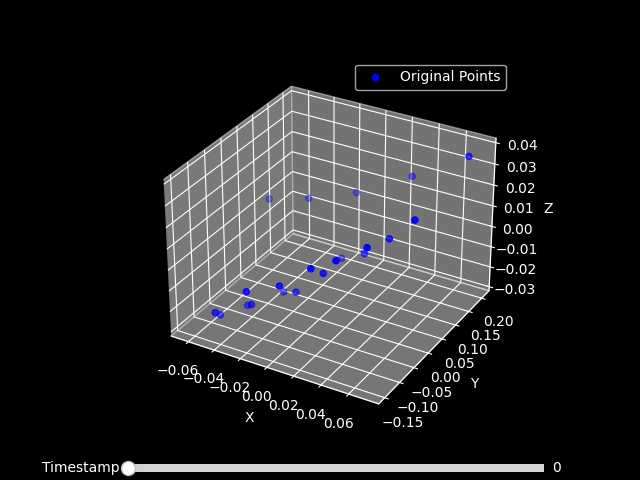

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import numpy as np

# Assuming normalized_points is a NumPy array with shape (n, 4) where the last column represents the timestamp
# You should replace this with your actual data
normalized_points = a

# Create the figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial timestamp index
initial_timestamp_index = 0

# Plotting the original points for the initial timestamp
scatter = ax.scatter(normalized_points[initial_timestamp_index, :,0], 
                     normalized_points[initial_timestamp_index, :,1], 
                     normalized_points[initial_timestamp_index, :,2],
                     c='blue', label='Original Points')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Create a slider axes
ax_slider = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')

# Create a slider
slider = Slider(ax_slider, 'Timestamp', 0, normalized_points.shape[0] - 1, valinit=initial_timestamp_index, valstep=1)

# Update function for the slider
def update(val):
    timestamp_index = int(slider.val)
    
    # Update the scatter plot with the new points for the selected timestamp
    scatter._offsets3d = (normalized_points[timestamp_index, :,0],
                          normalized_points[timestamp_index, :,1],
                          normalized_points[timestamp_index, :,2])

    # Redraw the plot
    fig.canvas.draw_idle()

# Connect the slider to the update function
slider.on_changed(update)

plt.show()

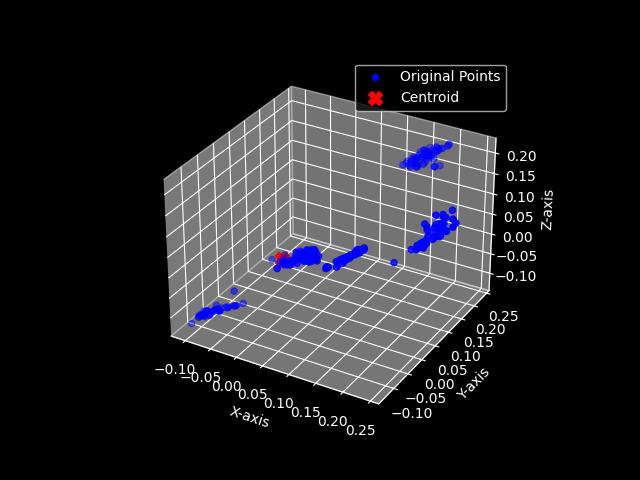

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the original points
ax.scatter(normalized_points[:, 0], normalized_points[:, 1], normalized_points[:, 2], c='blue', label='Original Points')

# Plotting the centroid
ax.scatter(0,0,0, c='red', marker='X', s=100, label='Centroid')

# Adding labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Display the 3D plot
plt.show()

NameError: name 'points_array' is not defined

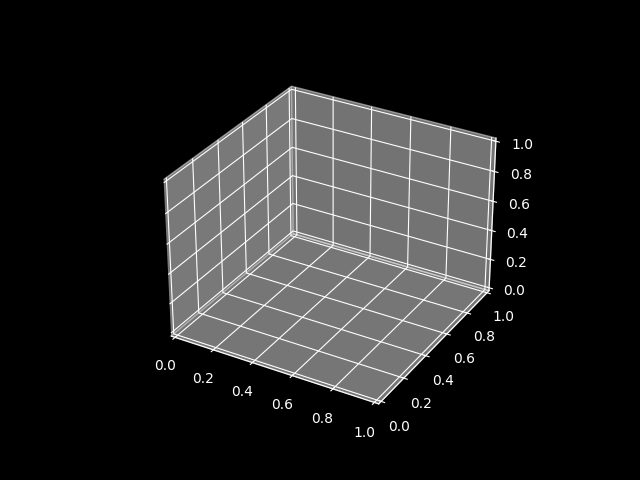

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the original points
ax.scatter(points_array[:, 0], points_array[:, 1], points_array[:, 2], c='blue', label='Original Points')

# Plotting the centroid
#ax.scatter(points_array[1, 0], points_array[1, 1], points_array[1, 2], c='red', marker='X', s=100, label='Centroid')
#ax.scatter(0,0,0, c='red', marker='X', s=100, label='Centroid')
# Adding labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Display the 3D plot
plt.show()

# VIEJO

In [ ]:
for etapa in range(1,7):
    cap = cv2.VideoCapture("Videos-home/Step"+str(etapa)+".mp4")#Videos-home/Paso1.mp4
    with mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands = 2, ) as hands:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
                break
            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            #image.flags.writeable = True
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            #Draw the hand annotations on the image.
            #image.flags.writeable = False
            #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            height, width, _ = image.shape

            if results.multi_hand_landmarks:

                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=3),
                    mp_drawing.DrawingSpec(color=(255,0,255), thickness=2, circle_radius=3))

                # verificar primero la cantidad de landmarks
                if len(results.multi_hand_landmarks) == 1:
                    variable =results.multi_handedness[0].classification[0].label
                elif len(results.multi_hand_landmarks) == 2:
                    variable = 'Both'
                else:
                    variable = None

                #try:
                if variable =="Left":
                    mano_dere_row = np.zeros(63)
                    mano_izq_row = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark]).flatten()
                elif variable == "Right":
                    mano_izq_row = np.zeros(63)
                    mano_dere_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[0].landmark]).flatten()
                elif variable == "Both":
                    mano_dere_row = np.array([[landmark.x, landmark.y,landmark.z] for landmark in results.multi_hand_landmarks[0].landmark]).flatten()
                    mano_izq_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.multi_hand_landmarks[1].landmark]).flatten()
                else:
                    print('Error, se reconocen mas de dos manos')
                print("va en el paso", etapa)
                rows = np.concatenate((np.array([etapa]),mano_dere_row,mano_izq_row))
                print(rows)
                rows = np.where(rows ==0, np.nan,rows)
                centroid_x = np.nanmean(rows[1::3])
                centroid_y = np.nanmean(rows[2::3])
                centroid_z = np.nanmean(rows[3::3])
                rows = np.where(np.isnan(rows), 0, rows)
                rows[1::3] -= centroid_x
                rows[2::3] -= centroid_y
                rows[3::3] -= centroid_z
                    
                with open('Avianca2.csv', mode='a', newline='') as f:
                    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(rows) 

            cv2.imshow('Paso '+str(etapa), image)
            if cv2.waitKey(5) & 0xFF == 27:
                break
        cap.release()
        cv2.destroyAllWindows()